# Analys Zeitreihen
## Daten laden

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline  
#plt.rcParams['figure.figsize'] = [15, 10]
plt.style.use('seaborn')


In [225]:
data_path = r"C:\\Users\\Armin\\Documents\\Code\\Studienarbeit\\crypto_daten_kaggle\\"
crypto_df = pd.read_hdf('train.h5')
crypto_df.head(5)

,index,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.38,8.530000,-0.014399
1,9,1514764920,0,7.0,8.5300,8.5300,8.5145,8.5145,71.39,8.520215,-0.015875
2,17,1514764980,0,45.0,8.5065,8.5299,8.4848,8.4848,1546.82,8.501394,-0.015410
3,25,1514765040,0,14.0,8.5009,8.5066,8.4744,8.5009,125.80,8.479810,-0.012524
4,33,1514765100,0,5.0,8.5007,8.5007,8.4560,8.4560,125.01,8.458435,-0.005940


### Colum definitions
timestamp - A timestamp for the minute covered by the row. <br>
Asset_ID - An ID code for the cryptoasset. <br>
Count - The number of trades that took place this minute. <br>
Open - The USD price at the beginning of the minute. <br>
High - The highest USD price during the minute. <br>
Low - The lowest USD price during the minute. <br>
Close - The USD price at the end of the minute. <br>
Volume - The number of cryptoasset units traded during the minute. <br>
VWAP - The volume weighted average price for the minute. <br>
Target - 15 minute residualized returns. See the 'Prediction and Evaluation' section of this notebook for details of how the target is calculated. <br>

In [226]:
asset_details = pd.read_csv(data_path + 'asset_details.csv')
asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [227]:
crypto_df.isna().sum()

index        0
timestamp    0
Asset_ID     0
Count        0
Open         0
High         0
Low          0
Close        0
Volume       0
VWAP         9
Target       0
dtype: int64

--> 3 NaN - Problems

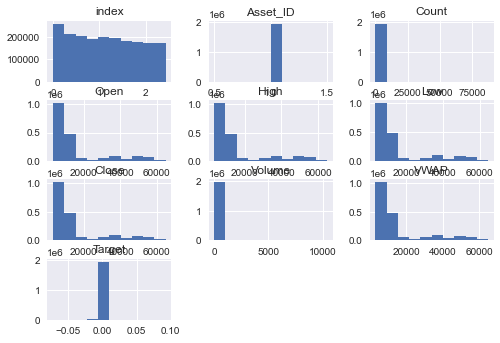

In [228]:
btc = crypto_df[crypto_df["Asset_ID"]==1].set_index("timestamp")
hist = btc.hist()

In [229]:
beg_btc = btc.index[0].astype('datetime64[s]')
end_btc = btc.index[-1].astype('datetime64[s]')


print('BTC data goes from ', beg_btc, 'to ', end_btc)

BTC data goes from  2018-01-01T00:01:00 to  2021-09-21T00:00:00


778


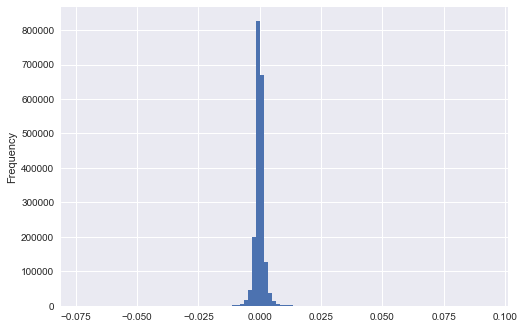

In [230]:
btc_target = btc["Target"].round(4)
print(btc_target.unique().size)
ax = btc_target.plot.hist(bins=100)

In [231]:
btc_target_plus = []
btc_target_minus = []
for index,value in btc_target.items():
    if value < 0:
        btc_target_minus.append(value)
    elif value > 0:
        btc_target_plus.append(value)
btc_target_plus = np.array(btc_target_plus)
btc_target_minus = np.array(btc_target_minus)


In [232]:
print(btc_target_plus)

[0.004  0.0032 0.0059 ... 0.0024 0.0033 0.0041]


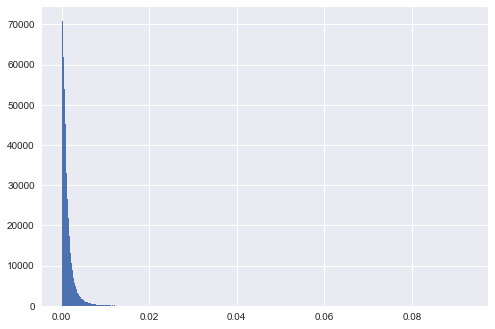

In [233]:
plt.hist(btc_target_plus,bins=np.unique(btc_target_plus))
plt.show()

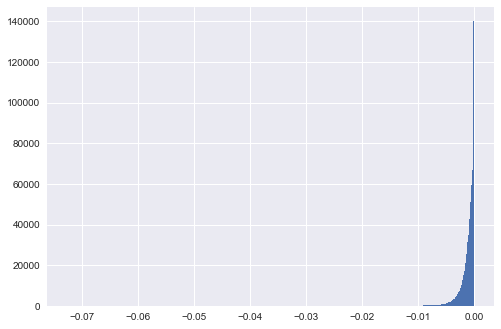

In [234]:
plt.hist(btc_target_minus,bins=np.unique(btc_target_minus))
plt.show()

## Plus Target

In [235]:
print("Durschnitt")
print(str(round(btc_target_plus.mean() * 100,2 ))+ "%")
print("Median")
print(str(round(np.median(btc_target_plus) * 100,2 ))+ "%")
print("Standardabweichung")
print(btc_target_plus.std()*100)


Durschnitt
0.13%
Median
0.08%
Standardabweichung
0.1705481963180124


## Minus Target

In [236]:
print("Durschnitt")
print(str(round(btc_target_minus.mean() * 100,2 ))+ "%")
print("Median")
print(str(round(np.median(btc_target_minus) * 100,2 ))+ "%")
print("Standardabweichung")
print(btc_target_minus.std()*100)


Durschnitt
-0.13%
Median
-0.08%
Standardabweichung
0.14974257018841752


Durschnitt und Median gleich Standardabweichung unterschiedlich -> breitere Verteilung bei Plus

In [237]:
btc["Target"].isna().sum()

0

# Klassifikator Umsetzung
2 Einheiten. 1 Einheitet prädiziert ob Klassifikator steigt anderer um wie viel. Klassifikationsproblem anstatt Regressionsproblem -> einfachrere Umsetzung.
## Klassifikator Datenvorbereitung
Klassifikator Label: <br>
    - Sell - 1 oder Buy - 0 <br>
    - Buy, Sell oder Hold 



In [238]:
btc_target_label = []

In [239]:
for index,value in btc["Target"].items():
    if value < 0:
        btc_target_label.append(1)
    elif value > 0:
        btc_target_label.append(0)
    else:
        btc_target_label.append(0)

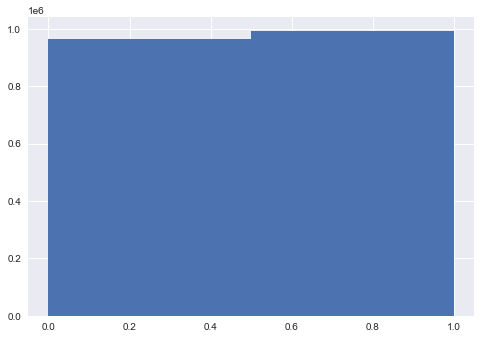

In [240]:
plt.hist(btc_target_label,bins=len(set(btc_target_label)))
plt.show()

In [241]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout
import tensorflow as tf

In [242]:
test_datensatz = pd.read_csv("example_test.csv")
btc_test = test_datensatz[test_datensatz["Asset_ID"]==1].set_index("timestamp")

In [243]:
model = Sequential()
model.add(Dense(256, input_dim=7, activation='relu'))
model.add(Dense(126, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [244]:
btc_y = np.array(btc_target_label)
btc_x = btc.drop(["Target","Asset_ID","index"], axis=1).reset_index(drop=True)

In [245]:
print(len(btc_y))
print(btc_x.shape[0])

1956282
1956282


In [246]:
#model.save_weights("./Models/model_1_nn")

In [247]:
# model.fit(
#     x = btc_x,
#     y = btc_y,
#     epochs=10, 
#     batch_size=10
# )

## LSTM

In [248]:
scaler = StandardScaler()
scaler = scaler.fit(btc_x)
btc_x_scaled = scaler.transform(btc_x)
btc_target_label = btc_target_label[:-96]

In [249]:
print(btc_x_scaled.shape)
print(len(btc_target_label))

(1956282, 7)
1956186


In [250]:
n_future = 1 #Naechste 15min prädizieren
n_past = 96 #(24*60)/15  --  letzte 24h mit einbeziehen

In [251]:
train_x = []
train_y = []
for i in range(n_past,len(btc_x_scaled)-n_future+1):
    train_x.append(btc_x_scaled[i-n_past:i, 0:btc_x_scaled.shape[1]])
train_x,train_y = np.array(train_x), np.array(btc_target_label)

In [252]:
print(train_x.shape)
print(train_y)

(1956186, 96, 7)
[1 1 1 ... 0 0 0]


In [253]:
model = Sequential()
model.add(LSTM(64,activation='tanh', input_shape=(96,7), return_sequences=True))
model.add(LSTM(32,activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [254]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 96, 64)            18432     
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_57 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30,881
Trainable params: 30,881
Non-trainable params: 0
_________________________________________________________________


In [255]:
model.fit(
    x = train_x,
    y = train_y,
    epochs=10, 
    batch_size=16
)

Epoch 1/10
122262/122262 [==============================] - 1256s 10ms/step - loss: 0.6930 - accuracy: 0.5078
Epoch 2/10
122262/122262 [==============================] - 1133s 9ms/step - loss: 0.6926 - accuracy: 0.5131
Epoch 3/10
122262/122262 [==============================] - 1111s 9ms/step - loss: 0.6923 - accuracy: 0.5157
Epoch 4/10
122262/122262 [==============================] - 1098s 9ms/step - loss: 0.6921 - accuracy: 0.5177
Epoch 5/10
122262/122262 [==============================] - 1056s 9ms/step - loss: 0.6919 - accuracy: 0.5192
Epoch 6/10
122262/122262 [==============================] - 1102s 9ms/step - loss: 0.6916 - accuracy: 0.5199
Epoch 7/10
122262/122262 [==============================] - 1105s 9ms/step - loss: 0.6918 - accuracy: 0.5198
Epoch 8/10
122262/122262 [==============================] - 1136s 9ms/step - loss: 0.6914 - accuracy: 0.5222
Epoch 9/10
122262/122262 [==============================] - 1136s 9ms/step - loss: 0.6914 - accuracy: 0.5220
Epoch 10/10
122262

In [256]:
# https://stackoverflow.com/questions/68844792/lstm-will-not-use-cudnn-kernels-since-it-doesnt-meet-the-criteria-it-will-use

In [ ]:
model.save_weights("./lstm/model_lstm_01")

## Resultat

Training dauert sehr lang.
Ergebnisse sind schlecht
Zu wenig Epochen

## Lösung
Filtern nach eindeutigen Ereignissen. <br>
Batch Size hochstellen <br>
Neue Features suchen: <br>
 -> Saisonalität <br>
 -> FFT <br>
 -> Indikatoren <br>
 -> Volumen - Volatilität <br>
 -> transformer <br>
 -> Pump and dump pattern <br>
